# Week 7

Xiaotian Li, 05/11/2022

## Introduction

Predict daily volume.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import os
import sys
sys.path.append('../')
import functions.Preprocess

# Daily Data

In [5]:
daily_data = pd.read_csv('../Data/SP500_daily_2021.csv', parse_dates=['DATE'], dtype={'symbol': 'category'}, usecols=['DATE', 'symbol', 'total_vol_m']) #
qqq = pd.read_csv('../data/qqq_symbol.csv')

#daily_data = daily_data[daily_data.symbol.isin(qqq.symbol)]
daily_data.DATE = pd.to_datetime(daily_data.DATE)
daily_data.reset_index(drop=True, inplace=True)
daily_data.rename(columns={'DATE': 'date'}, inplace=True)
daily_data['log_volume'] = daily_data['total_vol_m'].apply(lambda x: np.log(x))

daily_data.set_index('date', drop=False, inplace=True)

In [4]:
ls = daily_data.symbol.unique()

## Exploratory

In [26]:
example = daily_data[daily_data.symbol.isin(['UPS'])]

from functions.Preprocess import exclude_option_expiration
example = exclude_option_expiration(example)

In [29]:
example

,date,symbol,total_vol_m,log_volume
date,,,,
2021-01-04,2021-01-04,GOOGL,1720933.0,14.358377
2021-01-05,2021-01-05,GOOGL,941711.0,13.755454
2021-01-06,2021-01-06,GOOGL,2222492.0,14.614140
2021-01-07,2021-01-07,GOOGL,2023791.0,14.520483
2021-01-08,2021-01-08,GOOGL,1667563.0,14.326874
...,...,...,...,...
2021-12-27,2021-12-27,GOOGL,733129.0,13.505077
2021-12-28,2021-12-28,GOOGL,894935.0,13.704506
2021-12-29,2021-12-29,GOOGL,861956.0,13.666960


In [25]:
t = 59
daily_data.symbol.unique()[10*t:10*(t+1)]

['UPS', 'URI', 'USB', 'USBPRA', 'USBPRH', 'USBPRM', 'USBPRO', 'USBPRP', 'USBPRQ', 'V']
Categories (693, object): ['A', 'AAL', 'AAP', 'AAPL', ..., 'FRCPRN', 'IBMWI', 'MSPRO', 'PSAPRR']

### Smooth

In [10]:
def smooth(series):

    res = series.copy()
    n = series.shape[0]
    Forward = series.diff().abs().describe()
    Backward = series.diff(-1).abs().describe()
    F = 1.5 * (Forward['75%'] - Forward['25%'])
    B = 1.5 * (Backward['75%'] - Backward['25%'])

    for i in range(1, n):
        if i != n-1:
            if series.iloc[i] - series.iloc[i-1] >= F and series.iloc[i] - series.iloc[i+1] >= B:
                res.iloc[i] = (series.iloc[i-1] + series.iloc[i+1]) / 2
        else:
            if series.iloc[i] - series.iloc[i-1] >= F:
                res.iloc[i] = res.iloc[i-1] + F
    
    return res

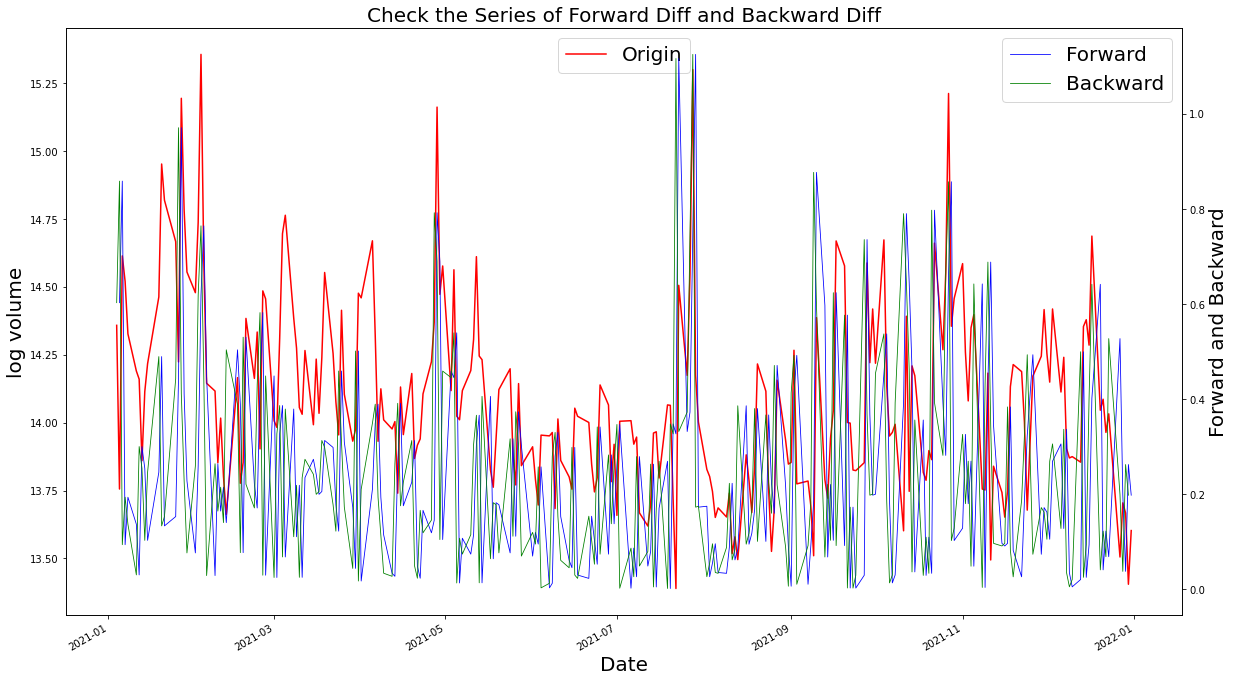

In [5]:
plt.figure(figsize=(20, 12))
example['log_volume'].plot(label='Origin', c='red')
plt.xlabel('Date', fontsize=20)
plt.ylabel('log volume', fontsize=20)
plt.legend(loc='upper center', fontsize=20)
plt.twinx()
example['log_volume'].diff().abs().plot(label='Forward', c='blue', linewidth=0.8)
example['log_volume'].diff(-1).abs().plot(label='Backward', c='green', linewidth=0.8)
plt.ylabel('Forward and Backward', fontsize=20)
plt.title('Check the Series of Forward Diff and Backward Diff', fontsize=20)
plt.legend(fontsize=20)
plt.show()

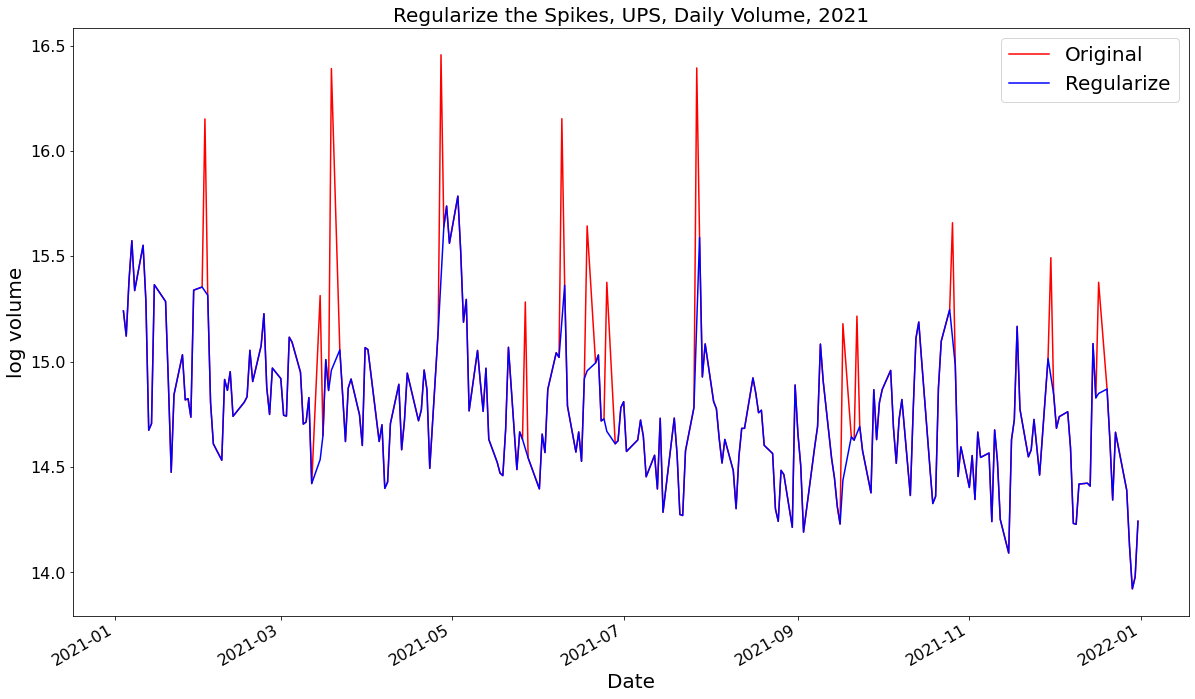

In [53]:
plt.figure(figsize=(20, 12))
plt.rcParams['font.size'] = 16
example['log_volume'].plot(label='Original', c='red')
smooth(example['log_volume']).plot(label='Regularize', c='blue')
plt.legend(fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('log volume', fontsize=20)
plt.title('Regularize the Spikes, UPS, Daily Volume, 2021', fontsize=20)

plt.show()

Test the models:

In [ ]:
example['pred_log_volume'] = example['log_volume']
example['pred_log_volume_s'] = example['log_volume']


from statsmodels.tsa.arima.model import ARIMA

mid = 150
for i in range(mid, example.shape[0]):
    model = ARIMA(example.iloc[:i]['log_volume'], order=(1, 0, 1))
    model_fit = model.fit()
    example['pred_log_volume'].iloc[i] = model_fit.forecast(1).iloc[0]
    
    model = ARIMA(smooth(example.iloc[:i]['log_volume']), order=(1, 0, 1))
    model_fit = model.fit()
    example['pred_log_volume_s'].iloc[i] = model_fit.forecast(1).iloc[0]


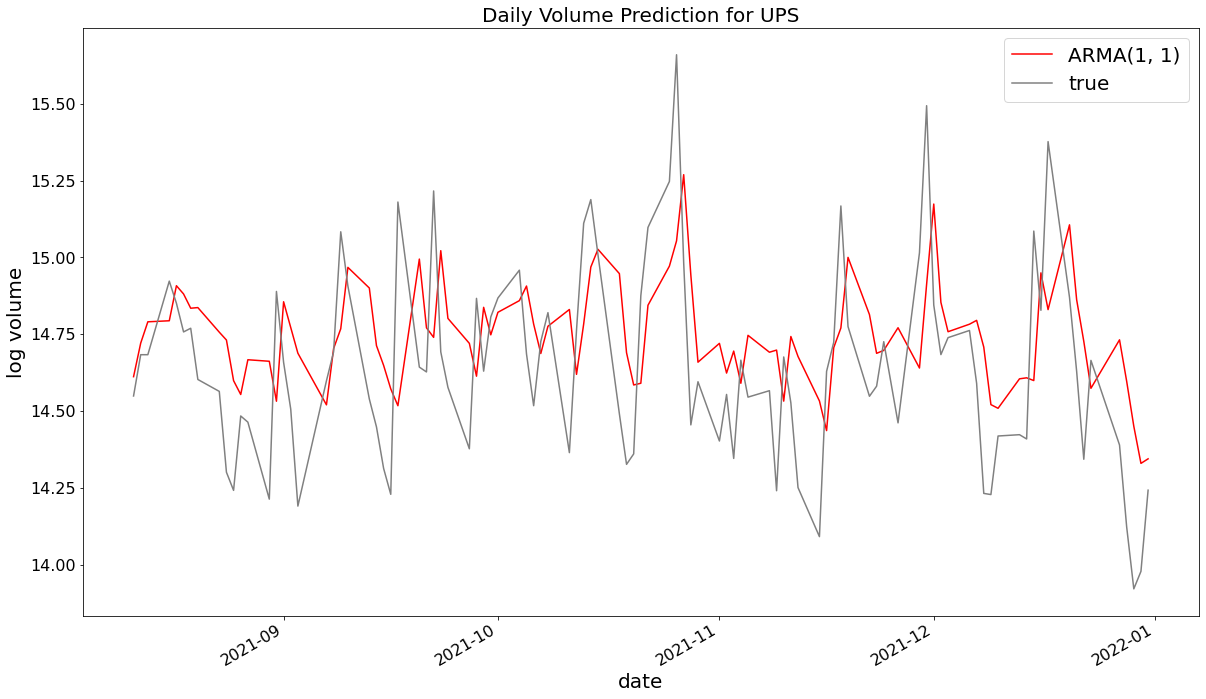

In [52]:
plt.figure(figsize=(20, 12))
plt.rcParams['font.size'] = 16
example['pred_log_volume'].iloc[mid:].plot(label='ARMA(1, 1)', c='red')
#example['pred_log_volume_s'].iloc[mid:].plot(label='Robust ARMA(1, 1)', c='blue')
#example['log_volume'].apply(lambda x: np.log(x)).rolling(20).mean().apply(lambda x: np.exp(x)).iloc[mid:].plot(label='baseline', c='red')
example['log_volume'].iloc[mid:].plot(label='true', c='gray')
plt.xlabel('date', fontsize=20)
plt.ylabel('log volume', fontsize=20)
plt.title('Daily Volume Prediction for UPS', fontsize=20)
plt.legend(fontsize=20)

In [30]:
f = lambda x: np.mean(abs((x['pred_log_volume'].iloc[mid:] - x['log_volume'].iloc[mid:]) / x['log_volume'].iloc[mid:]))
g = lambda x: np.mean(abs((x['log_volume'].apply(lambda x: np.log(x)).rolling(20).mean().apply(lambda x: np.exp(x)).iloc[mid:] - x['log_volume'].iloc[mid:]) / x['log_volume'].iloc[mid:]))
f_ = lambda x: np.mean(abs((x['pred_log_volume_s'].iloc[mid:] - x['log_volume'].iloc[mid:]) / x['log_volume'].iloc[mid:]))

print(g(example), f(example), f_(example))

0.016868255374565714 0.01712241986122981 0.015907341011515114


---

### Systematic

In [ ]:
from functions.Preprocess import exclude_option_expiration
from statsmodels.tsa.arima.model import ARIMA

# mean absolute percentage error of ARMA(1, 1)
f = lambda x: np.mean(abs((x['pred_log_volume'].iloc[mid:] - x['log_volume'].iloc[mid:]) / x['log_volume'].iloc[mid:]))
# mean absolute percentage error of robust ARMA(1, 1)
f_ = lambda x: np.mean(abs((x['pred_log_volume_s'].iloc[mid:] - x['log_volume'].iloc[mid:]) / x['log_volume'].iloc[mid:]))

n_stocks = daily_data.symbol.unique().shape[0]
Error = pd.DataFrame(data={'symbol': ['stock' for i in range(n_stocks)], 
                                                          'ARMA(1, 1)': [0 for i in range(n_stocks)],
                                                          'Robust ARMA(1, 1)': [0 for i in range(n_stocks)]})



for k in range(n_stocks):
    s = daily_data.symbol.unique()[k]
    curr_stock = daily_data[daily_data.symbol.isin([s])]
    curr_stock = exclude_option_expiration(curr_stock)

    curr_stock['pred_log_volume'] = curr_stock['log_volume']
    curr_stock['pred_log_volume_s'] = curr_stock['log_volume']

    mid = 150
    for i in range(mid, curr_stock.shape[0]):
        model = ARIMA(curr_stock.iloc[:i]['log_volume'], order=(1, 0, 1))
        model_fit = model.fit()
        curr_stock['pred_log_volume'].iloc[i] = model_fit.forecast(1).iloc[0]

        model = ARIMA(smooth(curr_stock.iloc[:i]['log_volume']), order=(1, 0, 1))
        model_fit = model.fit()
        curr_stock['pred_log_volume_s'].iloc[i] = model_fit.forecast(1).iloc[0]

    Error.loc[k, 'symbol'] = s
    Error.loc[k, 'ARMA(1, 1)'] = f(curr_stock)
    Error.loc[k, 'Robust ARMA(1, 1)'] = f_(curr_stock)

In [11]:
Error = Error[Error['ARMA(1, 1)'] != float('inf')]

In [39]:
Error[Error['ARMA(1, 1)'] != float('inf')].shape

(75, 3)

In [40]:
Error.describe()

,"ARMA(1, 1)","Robust ARMA(1, 1)"
count,75.000000,75.000000
mean,0.016767,0.016585
std,0.002698,0.002644
min,0.010151,0.010534
25%,0.015207,0.014852
50%,0.016791,0.016281
75%,0.018296,0.017902
max,0.023732,0.024006


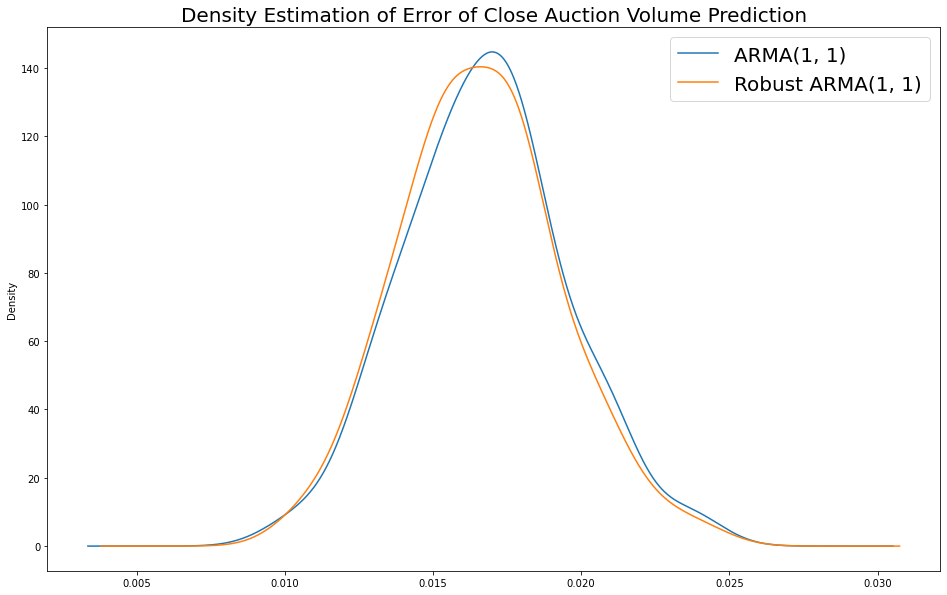

In [41]:
Error.plot.kde(figsize=(16, 10))
#plt.xlabel('date', fontsize=20)
#plt.ylabel(fontsize=20)
plt.title('Density Estimation of Error of Daily Volume Prediction', fontsize=20)
plt.legend(fontsize=20)

In [15]:
Error.to_csv('Error.csv', index=False)

In [45]:
sum(Error['ARMA(1, 1)'] > Error['Robust ARMA(1, 1)']) / Error.shape[0]

0.6666666666666666

In [42]:
import plotly.express as px

fig = px.bar(Error, x='symbol', y=['ARMA(1, 1)', 'Robust ARMA(1, 1)'], barmode='group')

fig.show()

In [ ]:
Error.to_csv('Error_daily.csv', index=False)

## Other

In [15]:
temp = pd.read_csv('./res/Error_daily_qqq.csv')

temp

,symbol,"ARMA(1, 1)","Robust ARMA(1, 1)"
0,ADBE,0.017486,0.017908
1,ADI,0.017780,0.018089
2,ADP,0.016291,0.015888
3,ADSK,0.017942,0.017665
4,AEP,0.015555,0.014947
...,...,...,...
70,VRSK,0.020686,0.020498
71,VRSN,0.018625,0.017191
72,VRTX,0.019171,0.018965
73,WBA,0.014385,0.014914


In [19]:
temp2 = pd.read_csv('./res/Error_test.csv')
temp2.describe()

,"ARMA(1, 1)","Robust ARMA(1, 1)"
count,75.000000,75.000000
mean,0.016529,0.016346
std,0.002593,0.002566
min,0.010415,0.010715
25%,0.014965,0.014778
50%,0.016562,0.016224
75%,0.018011,0.017723
max,0.023722,0.023992


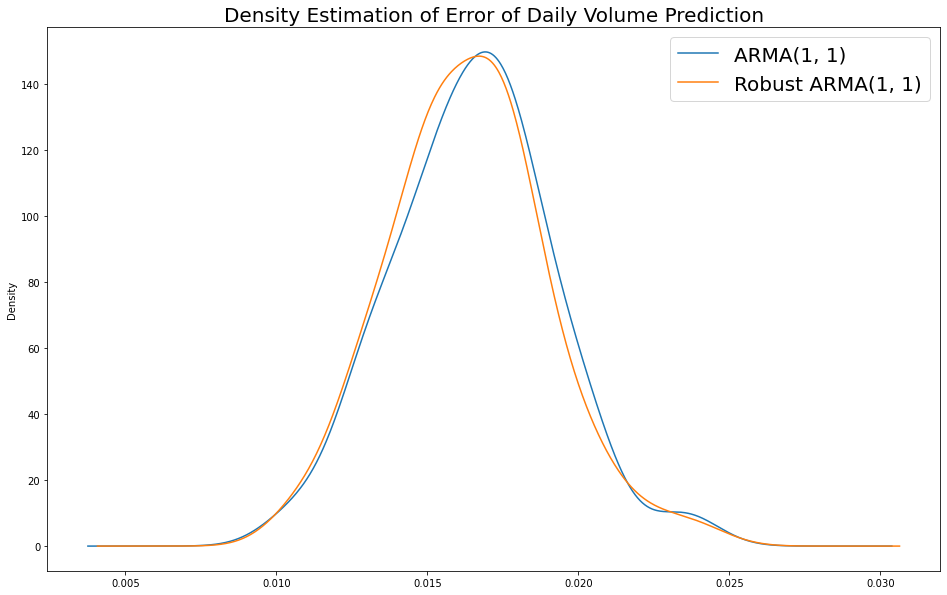

In [21]:
temp2.plot.kde(figsize=(16, 10))
#plt.xlabel('date', fontsize=20)
#plt.ylabel(fontsize=20)
plt.title('Density Estimation of Error of Daily Volume Prediction', fontsize=20)
plt.legend(fontsize=20)

In [30]:
sum(temp2['ARMA(1, 1)'] > temp2['Robust ARMA(1, 1)']) / temp2.shape[0]

0.68

In [31]:
sum(temp2['ARMA(1, 1)'] > temp2['Robust ARMA(1, 1)'])

51

In [29]:
import plotly.express as px

fig = px.bar(temp2, x='symbol', y=['ARMA(1, 1)', 'Robust ARMA(1, 1)'], barmode='group')

fig.show()

### SP500

In [10]:
SP500 = pd.read_csv('./res/Error_daily_SP500.csv')
SP500.dropna(inplace=True)
SP500 = SP500[SP500['ARMA(1, 1)'] != float('inf')]
SP500.reset_index(drop=True, inplace=True)

In [13]:
SP500.describe()

,"ARMA(1, 1)","Robust ARMA(1, 1)"
count,633.000000,633.000000
mean,0.026844,0.026421
std,0.027668,0.027625
min,0.009718,0.009586
25%,0.016242,0.015857
50%,0.018806,0.018398
75%,0.023376,0.022800
max,0.322761,0.322276


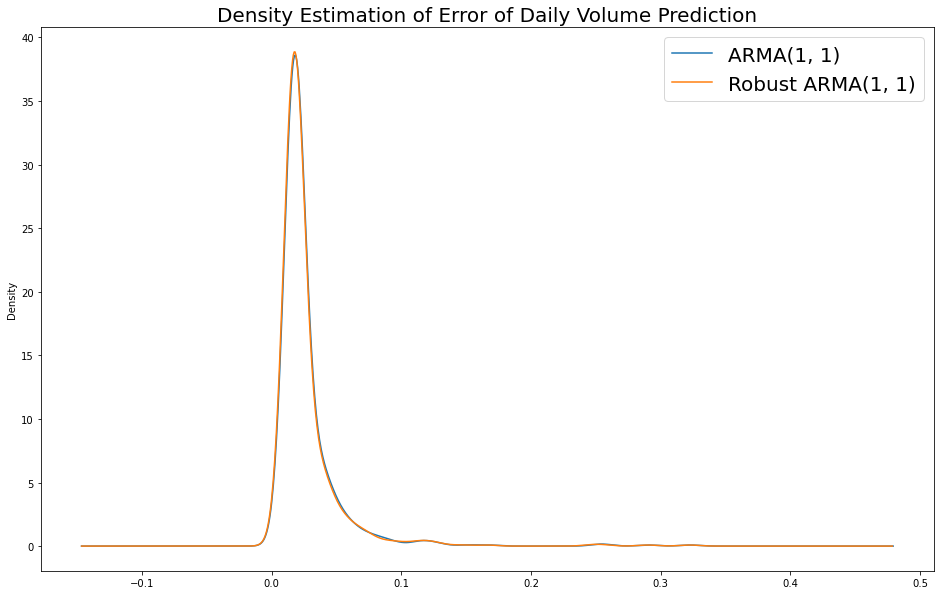

In [12]:
SP500.plot.kde(figsize=(16, 10))
#plt.xlabel('date', fontsize=20)
#plt.ylabel(fontsize=20)
plt.title('Density Estimation of Error of Daily Volume Prediction', fontsize=20)
plt.legend(fontsize=20)

## Russell 2021

In [2]:
russell = pd.read_csv('./res/Error_daily_russell_2021.csv')
russell.dropna(inplace=True)
russell = russell[russell['ARMA(1, 1)'] != float('inf')]
russell.reset_index(drop=True, inplace=True)

In [3]:
russell.describe()

,"ARMA(1, 1)","Robust ARMA(1, 1)"
count,150.000000,150.000000
mean,0.051538,0.051118
std,0.142479,0.140514
min,0.012229,0.011880
25%,0.019473,0.019350
50%,0.023558,0.023170
75%,0.034374,0.035010
max,1.495805,1.480788


In [11]:
diff = russell['ARMA(1, 1)'] - russell['Robust ARMA(1, 1)']
sum(diff > 0) / diff.shape[0]

0.5666666666666667

In [5]:
liq = pd.read_csv('../Data/russell/Russell_1000.txt', header=None)
iliq = pd.read_csv('../Data/russell/Russell_2000.txt', header=None)
set1 = set(liq.iloc[:, 0])
set2 = set(iliq.iloc[:, 0])
liq = set1.intersection(russell.symbol)
iliq = set2.intersection(russell.symbol)

liq_err = russell[russell.symbol.isin(liq)]
iliq_err = russell[russell.symbol.isin(iliq)]

In [6]:
liq_err.describe()

,"ARMA(1, 1)","Robust ARMA(1, 1)"
count,48.000000,48.000000
mean,0.018316,0.018183
std,0.003528,0.003559
min,0.012229,0.011880
25%,0.015729,0.015429
50%,0.018561,0.018335
75%,0.020427,0.020443
max,0.026631,0.025670


In [7]:
diff = liq_err['ARMA(1, 1)'] - liq_err['Robust ARMA(1, 1)']
sum(diff > 0) / diff.shape[0]


0.625

In [8]:
iliq_err.describe()

,"ARMA(1, 1)","Robust ARMA(1, 1)"
count,83.000000,83.000000
mean,0.030535,0.030390
std,0.015691,0.016129
min,0.013366,0.013154
25%,0.021838,0.021581
50%,0.024931,0.024987
75%,0.033792,0.033731
max,0.116222,0.123518


In [9]:
diff = iliq_err['ARMA(1, 1)'] - iliq_err['Robust ARMA(1, 1)']
sum(diff > 0) / diff.shape[0]


0.5783132530120482

In [17]:
diff = pd.concat([liq_err['ARMA(1, 1)'] - liq_err['Robust ARMA(1, 1)'], iliq_err['ARMA(1, 1)'] - iliq_err['Robust ARMA(1, 1)']])
sum(diff > 0) / diff.shape[0]

0.5954198473282443

In [37]:
from scipy.stats import wilcoxon
wilcoxon(russell['ARMA(1, 1)'], russell['Robust ARMA(1, 1)'], alternative='greater')

WilcoxonResult(statistic=6595.0, pvalue=0.04009425713950615)

In [39]:
wilcoxon(liq_err['ARMA(1, 1)'], liq_err['Robust ARMA(1, 1)'], alternative='greater')

WilcoxonResult(statistic=774.0, pvalue=0.02821387624399008)

In [40]:
wilcoxon(iliq_err['ARMA(1, 1)'], iliq_err['Robust ARMA(1, 1)'], alternative='greater')

WilcoxonResult(statistic=2096.0, pvalue=0.054504052910584896)

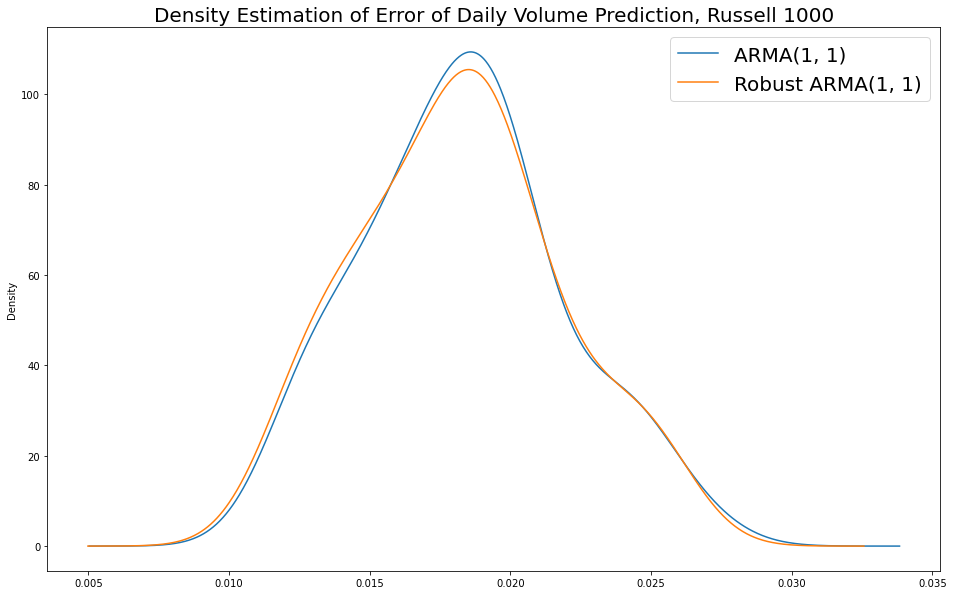

In [11]:
liq_err.plot.kde(figsize=(16, 10))
#plt.xlabel('date', fontsize=20)
#plt.ylabel(fontsize=20)
plt.title('Density Estimation of Error of Daily Volume Prediction, Russell 1000', fontsize=20)
plt.legend(fontsize=20)

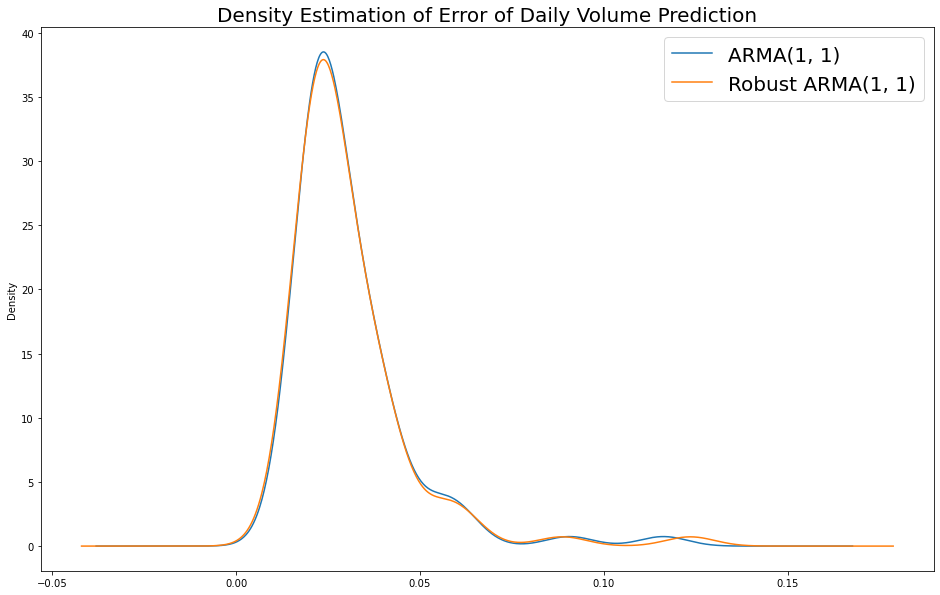

In [10]:
iliq_err.plot.kde(figsize=(16, 10))
#plt.xlabel('date', fontsize=20)
#plt.ylabel(fontsize=20)
plt.title('Density Estimation of Error of Daily Volume Prediction', fontsize=20)
plt.legend(fontsize=20)

Text(0.5, 1.0, 'Differential Error Series: Baseline ARMA $-$ Robust ARMA')

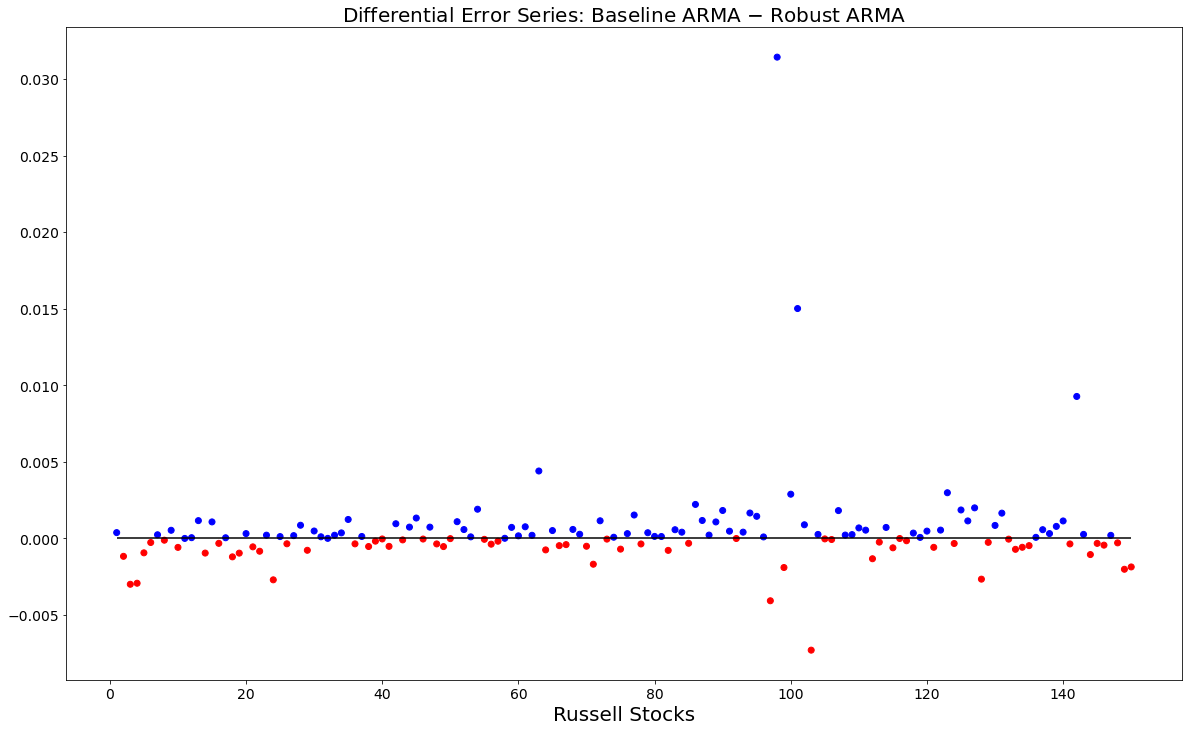

In [42]:
diff = russell['ARMA(1, 1)'] - russell['Robust ARMA(1, 1)']
xs = [i+1 for i in range(russell.shape[0])]
diff_color = diff.apply(lambda x: 'red' if x < 0 else 'blue')

plt.figure(figsize=(20, 12))
plt.rcParams['font.size'] = 14
plt.scatter(xs, diff, c=diff_color, s=36)
plt.hlines(y=0, xmin=1, xmax=russell.shape[0], colors='black')

plt.xlabel('Russell Stocks', fontsize=20)
plt.ylabel('', fontsize=20)
plt.title('Differential Error Series: Baseline ARMA $-$ Robust ARMA', fontsize=20)
#plt.legend(fontsize=20)

In [44]:
diff = russell['ARMA(1, 1)'] - russell['Robust ARMA(1, 1)']
sum(diff > 0) / diff.shape[0]


0.5666666666666667

In [89]:
diff

0                                                 0.000382
1                                                -0.001167
2                                                -0.002992
3                                                -0.002925
4                                                -0.000939
                               ...                        
146                                               0.000203
147                                              -0.000288
148                                              -0.002012
149                                              -0.001861
color    0      blue
1       red
2       red
3       re...
Length: 151, dtype: object

\begin{block}{Something to be Considered:}
\begin{enumerate}
    \item The hyper-parameter in threshold can be tuned;
    \item We adjust the data before we knew it is a spike;
    \item We only adjust upward spikes;
    \item Detect the spikes is similar with detecting jumps in a sense;
\end{enumerate}
\end{block}